# Using Amazon SageMaker Debugger for PyTorch Training Jobs

Amazon SageMaker is a managed platform to build, train and host machine learning models. Amazon SageMaker Debugger is a new feature which offers capability to debug machine learning and deep learning models during training by identifying and detecting problems with the models in real time.

Amazon SageMaker also gives you the option of bringing your own algorithms packaged in a custom container, that can then be trained and deployed in the Amazon SageMaker environment. 

This notebook guides you through an example of using your own container with PyTorch for training, along with the recently added feature, Amazon SageMaker Debugger.

## How does Amazon SageMaker Debugger work?

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in real time using rules and CloudWatch events and react to issues like, for example, common training issues such as vanishing gradients or poor weight initialization.

### Concepts

* **Output Tensor**: These are the artifacts that define the state of the training job at any particular instant in its lifecycle.
* **Debug Hook**: Captures the tensors flowing through the training computational graph every N steps.
* **Debugging Rule**: Logic to analyze the tensors captured by the hook and report anomalies.

With these concepts in mind, let's understand the overall flow of things which Amazon SageMaker Debugger uses to orchestrate debugging.

It operates in two steps - saving tensors and analysis.

### Saving tensors

Tensors that debug hook captures are stored in S3 location specified by you. There are two ways you can configure Amazon SageMaker Debugger for storage:

   1. **Zero code change**: If you use any of SageMaker provided [Deep Learning containers](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) then you don't need to make any changes to your training script for tensors to be stored. Amazon SageMaker Debugger will use the configuration you provide in the framework `Estimator` to save tensors in the fashion you specify.
       
       **Note**: In case of PyTorch training, Debugger collects output tensors in GLOBAL mode by default. In other words, this option does not distinguish output tensors from different phases within an epoch, such as training phase and validation phase.
       
   2. **Script change**: Use the SageMaker Debugger client library, SMDebug, and customize training scripts to save the specific tensors you want at different frequencies and configurations. Refer to the [DeveloperGuide](https://github.com/awslabs/sagemaker-debugger/tree/master/docs) for details on how to use SageMaker Debugger with your choice of framework in your training script.
   
In this notebook, we choose the second option to properly save the output tensors from different training phases.

### Analysis of tensors

Once tensors are saved, Amazon SageMaker Debugger can be configured to run debugging ***Rules*** on them. On a very broad level, a rule is a python script used to detect certain conditions during training. Some of the conditions that a data scientist training an algorithm might be interested in are monitoring for gradients getting too large or too small, detecting overfitting, and so on. Amazon SageMaker Debugger comes pre-packaged with certain built-in rules. You can also write your own rules using the Amazon SageMaker Debugger APIs. You can also analyze raw tensor data outside of the Rules construct in a notebook, using Amazong Sagemaker Debugger's full set of APIs.

## Import SageMaker Python SDK and check its version

In [ ]:
import sagemaker
sagemaker.__version__

This notebook works with the SageMaker Python SDK version **2.39.1 or later**.

## Modify a PyTorch training script

We will focus on how to modify a training script to save tensors by registering debug hooks and specifying which tensors to save.

The model used for this notebook is trained with the MNIST dataset. The example is based on https://github.com/pytorch/examples/blob/master/mnist/main.py (the version as of October 2020).

### Modifying the training script

Before we define a PyTorch estimator and start training, we will explore parts of the training script in detail. (The entire training script can be found at [./scripts/pytorch_mnist.py](./scripts/pytorch_mnist.py)).

- **Step 1**: Import Amazon SageMaker Debugger client library, SMDebug.

    ```python
    import smdebug.pytorch as smd
    
    ```


- **Step 2**: In the `train()` function, add the SMDebug hook for PyTorch with `TRAIN` mode.

    ```python
    hook.set_mode(smd.modes.TRAIN)
    ```


- **Step 3**: In the `test()` function, add the SMDebug hook for PyTorch with `EVAL` mode.

    ```python
    hook.set_mode(smd.modes.EVAL)
    ```


- **Step 4**: In the `main()` function, create the SMDebug hook and register to the model.

    ```python
    hook = smd.Hook.create_from_json_file()
    hook.register_hook(model)
    ```


- **Step 4**: In the `main()` function, pass the SMDebug hook to the `train()` and `test()` functions in the epoch loop.

    ```python
    train(args, model, device, train_loader, optimizer, epoch, hook)
    test(model, device, test_loader, hook)
    ```

In [17]:
!pygmentize ./scripts/pytorch_mnist.py

# The official PyTorch CNN model with MNIST training script
# https://github.com/pytorch/examples/blob/master/mnist/main.py

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

#====================================#
# 1. Import SMDebug framework class. #
#====================================#
import smdebug.pytorch as smd


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
   

## Set up a PyTorch estimator and run a training job

Once these changes are made in the training script, Amazon SageMaker Debugger will start saving tensors during training into a specfied output S3 bucket.

Now, we will set up the estimator and start training using the modified training script.

In [ ]:
from __future__ import absolute_import

import boto3
import pytest
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, rule_configs

Define the configuration of training to run. `ecr_image` is where you can provide link to your bring-your-own-container. `hyperparameters` are fed into the training script with data directory (directory where the training dataset is stored) and smdebug directory (directory where the tensors will be saved) are mandatory fields.

In [ ]:
hyperparameters={
    "epochs": "5",
    "batch-size": "32",
    "test-batch-size": "100"
}

### Configure a Debugger rule object

The `rules` parameter is a new parameter that accepts a list of rules against output tensors that you want to evaluate.

In this example, we use the VanishingGradient which will attempt to evaluate if there are overfit, overtraining, and vanishing gradients problems.

In [ ]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining())
]

### Configure Debugger hook parameters

The following code shows how to adjust save intervals of the output tensors in the different training phases.

In [ ]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

### Construct a PyTorch estimator with the Debugger parameters

In [ ]:
estimator = PyTorch(
    entry_point='scripts/pytorch_mnist.py',
    base_job_name='smdebugger-demo-mnist-pytorch',
    role=get_execution_role(),
    instance_count=1,
    instance_type='ml.p2.xlarge',
    volume_size=400,
    max_run=3600,
    hyperparameters=hyperparameters,
    framework_version='1.8.1',
    py_version='py36',
    ## New parameter
    rules = rules,
    debugger_hook_config=hook_config
)

### Start the traning job

In [ ]:
estimator.fit(wait=False)

## Check SageMaker Debugger rule summaries

As a result of calling the `fit()` method, Amazon SageMaker Debugger starts a rule evaluation job to monitor `vanishing_gradient()`, `overfit()`, and `overtraining()` issues in parallel with the training job. 

The `ProfilerReport` rule runs for all SageMaker training jobs by default. You will be able to receive a comprehensive training report regarding system bottlenecks and framework profiling.

### Print the latest training job's rule summary

In [ ]:
rule_summary=estimator.latest_training_job.rule_job_summary()

In [75]:
for r in range(len(rule_summary)):
    print(rule_summary[r]['RuleConfigurationName'], ": ", rule_summary[r]['RuleEvaluationStatus'])
    if rule_summary[r]['RuleEvaluationStatus']=='IssuesFound':
        print(rule_summary[r]['StatusDetails'])
    print("==================================================")

VanishingGradient :  NoIssuesFound
Overfit :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 4000 resulted in the condition being met

Overtraining :  NoIssuesFound
ProfilerReport-1620690228 :  NoIssuesFound


### Print URLs to the corresponding CloudWatch processing job logs

In [ ]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
        """Helper function to get the rule job name with correct casing"""
        return "{}-{}-{}".format(
            training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
        )
    
def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(region, region, rule_job_name)


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]
    
    result={}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"])
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(rule_job_name, region)
    return result

get_rule_jobs_cw_urls(estimator)

## SageMaker Debugger Reports and Analysis

Another aspect of the Amazon SageMaker Debugger is analysis. It allows us to perform interactive exploration of the tensors saved in real time or after the job. Here we focus on after-the-fact analysis of the above job. We import the smdebug library, which defines a concept of Trial that represents a single training run. Note how we fetch the path to debugger artifacts for the above job.

In [ ]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])  
        
import_or_install('smdebug')

### Create an SMDebug trial object and retrieve saved output tensors

In [ ]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

### Print check what output tensors are saved

We can list all the tensors that were recorded to know what we want to plot.

In [28]:
trial.tensor_names()

[2021-05-10 23:59:20.550 ip-172-16-71-4:24586 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-05-10 23:59:21.574 ip-172-16-71-4:24586 INFO trial.py:210] Loaded all steps


['gradient/Net_conv1.bias',
 'gradient/Net_conv1.weight',
 'gradient/Net_conv2.bias',
 'gradient/Net_conv2.weight',
 'gradient/Net_fc1.bias',
 'gradient/Net_fc1.weight',
 'gradient/Net_fc2.bias',
 'gradient/Net_fc2.weight',
 'nll_loss_output_0']

We can also retrieve tensors by some default collections that smdebug creates from your training job. Here we are interested in the losses collection, so we can retrieve the names of tensors in losses collection as follows. Amazon SageMaker Debugger creates default collections such as weights, gradients, biases, losses automatically. You can also create custom collections from your tensors.

### Check the number of steps saved in the different training phases

In [31]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))

94

In [32]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))

50

### Set up functions to log and plot the output tensors

In [122]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10,7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    p1, = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    p2, = par.plot(steps_eval, vals_eval, label="val_"+tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


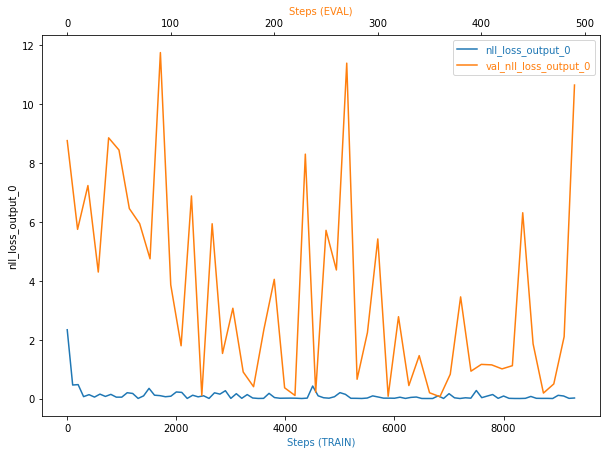

In [124]:
plot_tensor(trial, "nll_loss_output_0")

### Reflect the rule summary report

Recall what the rule summary reported:

```
Overfit :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule Overfit at step 4000 resulted in the condition being met
```

Based on this rule evaluation and the plot above, we can conclude that the training job has an overfit issue. While the `nll_loss_output_0` line is decreasing, the `val_nll_loss_output_0` line is fluctuating and not decreasing.

### Download, open, and display the ProfilerReport HTML file

In [ ]:
import os
#get name of profiler report
profiler_report_name = [rule["RuleConfigurationName"]
                        for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]][0]
base_output_path = os.path.dirname(estimator.latest_job_debugger_artifacts_path())
rule_output_path = os.path.join(base_output_path, "rule-output/")
profile_report_path = os.path.join(rule_output_path, profiler_report_name)

In [ ]:
estimator.output_path

In [ ]:
estimator.latest_training_job.job_name

In [ ]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
from IPython.display import FileLink
profiler_report_name = [rule["RuleConfigurationName"]
                        for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]][0]
profiler_report_name
display("Click link below to view the profiler report", FileLink(profiler_report_name+"/profiler-output/profiler-report.html"))

In [110]:
import IPython
IPython.display.HTML(filename=profiler_report_name+"/profiler-output/profiler-report.html")